#### import Python libraries

In [1]:
import copy
import itertools
import os
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))

In [3]:
import motmetrics as mm
from mot.data.data_track import MOT16Sequence
from mot.models.object_detector import FRCNN_FPN
from mot.tracker.intermediate import BaselineTracker
from mot.visualize import plot_sequence

mm.lap.default_solver = "lap"

In [4]:
seed = 735
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.


# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


## Configuration

In [5]:
obj_detect_model_file = os.path.join(root_dir, "models/faster_rcnn_fpn.model")
obj_detect_nms_thresh = 0.3

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)

# Multi-object tracking

provide simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union. Note that the output bounding boxes of the detection network are of format (x1, y1, x2, y2). Hence, we need to reformulate them to be used for the iou_matrix computation with py-motmetrics to format (x1, y1, w, h).

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [7]:
seq_name = "MOT16-02"
data_dir = os.path.join(root_dir, "data/MOT16")
output_dir = os.path.join(root_dir, "output")

In [8]:
from mot.utils import ltrb_to_ltwh

In [9]:
seq = MOT16Sequence(data_dir, seq_name=seq_name)

# Check single batch

In [10]:
seq_it = iter(seq)

In [11]:
single_frame = next(seq_it)
print(f"single_frame_keys = {(single_frame).keys()}")

print(f"frame shape = {single_frame['img'].shape}")
print(f"frame img_path = {single_frame['img_path']}")
print(f"frame vis  = {single_frame['vis'].keys()}")
print(f"frame vis  = {single_frame['vis'][8]}")

single_frame_keys = dict_keys(['img', 'img_path', 'gt', 'vis'])
frame shape = torch.Size([3, 1080, 1920])
frame img_path = ../data/MOT16/train/MOT16-02/img1/000001.jpg
frame vis  = dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
frame vis  = 0.51351


In [12]:
print(f"frame gt  = {single_frame['gt'].keys()}")
print(f"frame gt  = {single_frame['gt'][3]}")
print(f"frame gt  = {single_frame['gt'][8]}")

frame gt  = dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
frame gt  = [585. 446. 669. 708.]
frame gt  = [1415.  430. 1598.  765.]


# Track
object that stores for each box score and track_id belonging (through all frames)

class Track:

    """This class contains all necessary for every individual track."""

	def __init__(self, box, score, track_id):
		self.id = track_id
		self.box = box
		self.score = score



# Tracker
- Receives neural network input - detector
- reset - resets the accumulated detections.
- add - creates a new track object with the new track_id
- data_association - method that defines how to process the new frame in relation to the previous one and how to interpret the new boxes

# var 1: new img = new tracks

In [13]:
print(f"check how tracker work on single sequences of frames = {seq_name}")
print(f"in sequence = {seq_name} N frames =  {len(seq)}")

check how tracker work on single sequences of frames = MOT16-02
in sequence = MOT16-02 N frames =  600


In [14]:
empty_tracker = BaselineTracker(obj_detect)

sequence - dataset, each element of which is a dict and contains

- image tensor
- image path
- gt_bbox bbox_id - [x,y,x,y]
- visibility of persons above which they are selected

### Create short seq = 10 


In [15]:
empty_tracker.reset()
print(f"Tracking: {seq}")
data_loader = DataLoader(seq, batch_size=1, shuffle=False)
firstn_loader = itertools.islice(data_loader, 10)
for frame in tqdm(firstn_loader):
    empty_tracker.step(frame)

results = empty_tracker.get_results()
print(f"Tracks found: {len(results)}")

Tracking: MOT16-02


0it [00:00, ?it/s]

Tracks found: 162


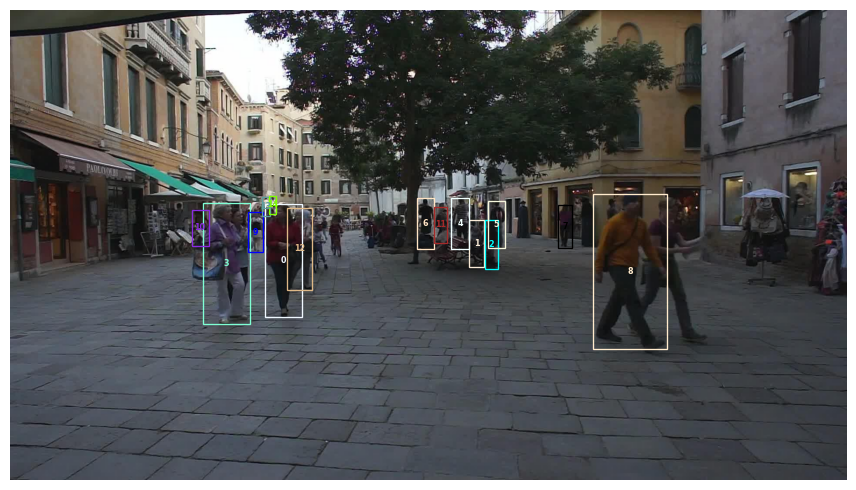

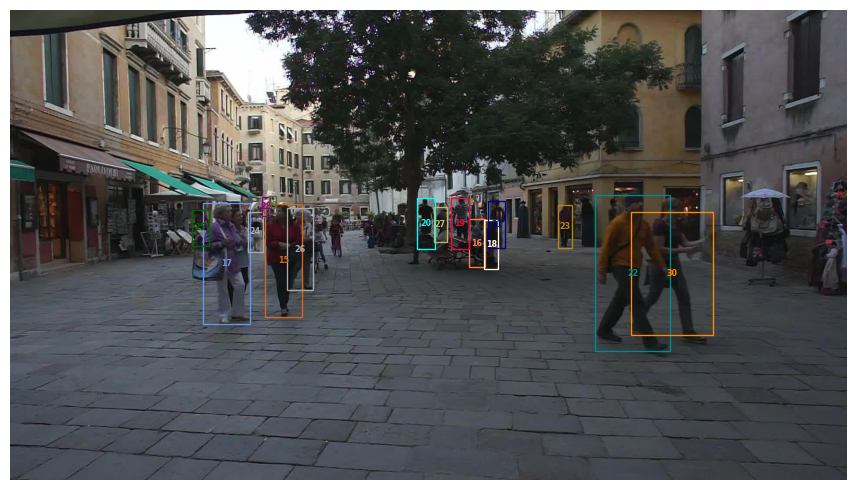

In [16]:
plot_sequence(results, seq, first_n_frames=2)

## Result: on each frame - new detections, no tracking between frames

# Check in details distance matrix and track assotiation

In [17]:
distance = np.matrix(
    [
        [np.nan, np.nan, np.nan, np.nan, np.nan],
        [0.01, np.nan, np.nan, np.nan, np.nan],
        [np.nan, 0.02, np.nan, np.nan, np.nan],
        [np.nan, np.nan, np.nan, np.nan, np.nan],
        [np.nan, np.nan, 0.02, np.nan, np.nan],
        [np.nan, np.nan, 0.01, 0.3, np.nan],
        [np.nan, np.nan, np.nan, 0.03, np.nan],
    ]
)
# num rows = num old(existing on frame t-1) tracks
# less is better -> 0 when the rectangles overlap perfectly and 1 when the overlap is zero.
# np.nan  if there is no overlap above the iou treshold
distance

matrix([[ nan,  nan,  nan,  nan,  nan],
        [0.01,  nan,  nan,  nan,  nan],
        [ nan, 0.02,  nan,  nan,  nan],
        [ nan,  nan,  nan,  nan,  nan],
        [ nan,  nan, 0.02,  nan,  nan],
        [ nan,  nan, 0.01, 0.3 ,  nan],
        [ nan,  nan,  nan, 0.03,  nan]])

In [18]:
tracks = [i for i in range(distance.shape[0])]
print("exiting tracks indexes on frame t-1", tracks)

exiting tracks indexes on frame t-1 [0, 1, 2, 3, 4, 5, 6]


In [19]:
remove_track_ids = []
for t, dist in zip(tracks, distance):
    # if there is no connection between the existing bbox and the new ones,
    # then in the distance matrix all values = np.nan
    # such a track is considered completed and will not be tracked further
    if np.isnan(dist).all():
        print(f"all nans for existing track {t}")
        remove_track_ids.append(t)
    else:
        match_id = np.nanargmin(dist)
        print(f"for old track = {t} new bbox match_id = {match_id}")
        # t.box = boxes[match_id]
new_tracks = [t for t in tracks if t not in remove_track_ids]

all nans for existing track 0
for old track = 1 new bbox match_id = 0
for old track = 2 new bbox match_id = 1
all nans for existing track 3
for old track = 4 new bbox match_id = 2
for old track = 5 new bbox match_id = 2
for old track = 6 new bbox match_id = 3


In [20]:
print("tracks indexes after proceed one frame:", new_tracks)

tracks indexes after proceed one frame: [1, 2, 4, 5, 6]
